# OSMM geopackage

Look at Ordinance Survey Master Maps geopackage files.

## Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import mplleaflet
import folium
import fiona
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_column', 100) #set max number of cols to display before ...

from rasterio._base import gdal_version
import rasterio
import contextily
import shapely

In [2]:
#check correct environment is being used: parkprov
print(sys.executable)

/Users/tamsinforbes/anaconda3/envs/parkprov/bin/python


## Load geopackage

- geopackage has layernames, unless specified only the first will be read in when using gpd.read_file()

https://gis.stackexchange.com/questions/307749/open-gpkg-embedded-layers-in-python
- read_file uses fiona

### Ealing highways network 10.5 MB

In [38]:
ehl_path = "../data/OSHighwaysNetworkApril2020_Ealing.gpkg"

In [39]:
for layername in fiona.listlayers(ehl_path):
    with fiona.open(ehl_path, layer=layername) as src:
        print(layername, len(src))

RoadLink 13507
Structure 1414
RoadNode 11017
RestrictionForVehicles 49
AccessRestriction 183


In [51]:
ehl = gpd.read_file(ehl_path, layer="RoadLink")

In [52]:
print(ehl.shape)
print(ehl.dtypes)

(13507, 40)
OBJECTID                             int64
TOID                                object
identifier                          object
identifierVersionId                 object
beginLifespanVersion                object
fictitious                           int64
validFrom                           object
reasonForChange                     object
roadClassification                  object
routeHierarchy                      object
formOfWay                           object
trunkRoad                            int64
primaryRoute                         int64
roadClassificationNumber            object
roadName1_Name                      object
roadName2_Name                      object
roadName1_Language                  object
roadName2_Language                  object
operationalState                    object
provenance                          object
directionality                      object
length                             float64
matchStatus                         object

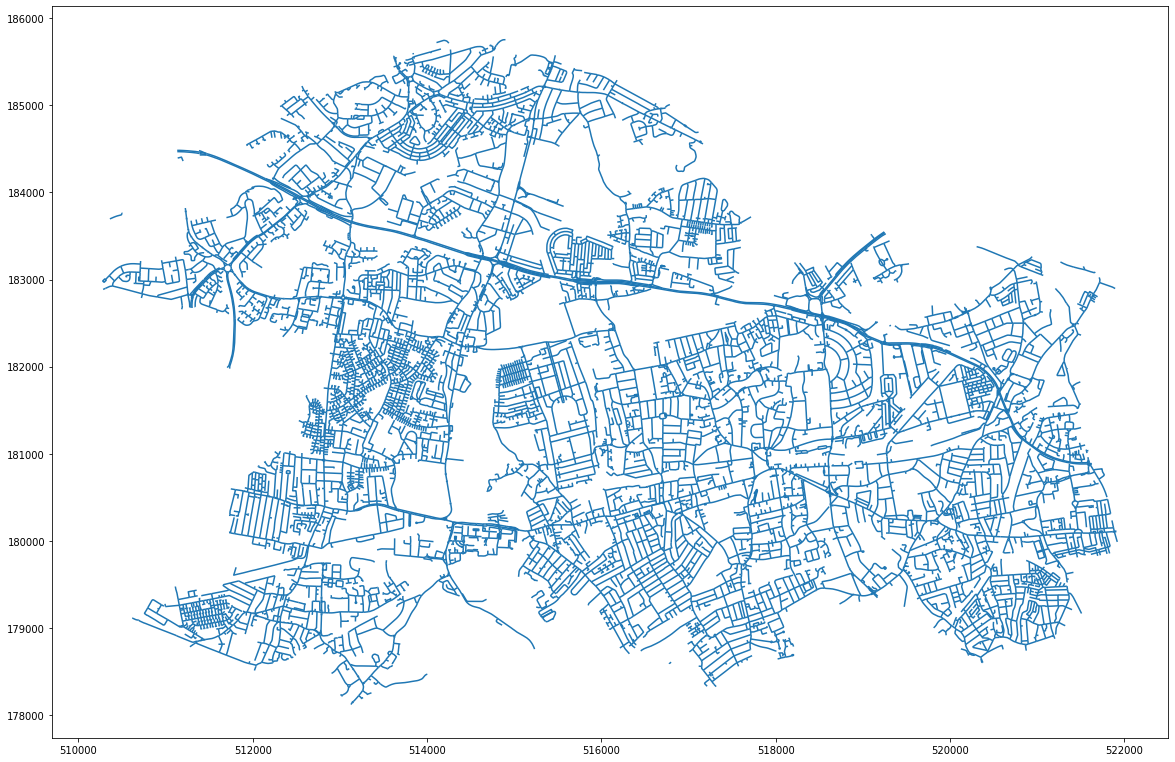

In [53]:
ehl.plot(figsize=(20,20))

### Ealing address base 213.6 MB
Need to read up on the tech specs for the AddressBase product - what do all the column variables mean

#### Layers:
- BasicLandPropertyUnit_point 181636; point geometry
- DeliveryPointAddress 136675
- ApplicationCrossReferenceMember 825858; no geometry
- LandPropertyIdentifierMember 185119
- ClassificationMember 202749
- Street_point 181636
- OrganisationMember 938

In [31]:
eab_path = "../data/OSAddressbaseApril2020_Ealing.gpkg"

In [32]:
for layername in fiona.listlayers(eab_path):
    with fiona.open(eab_path, layer=layername) as src:
        print(layername, len(src))

BasicLandPropertyUnit_point 181636
DeliveryPointAddress 136675
ApplicationCrossReferenceMember 825858
LandPropertyIdentifierMember 185119
ClassificationMember 202749
Street_point 181636
OrganisationMember 938


In [101]:
eab = gpd.read_file(eab_path, layer="ApplicationCrossReferenceMember")
#This took 36 seconds
#DeliveryPointAddress contains postcodeType with value S for small user eg residential property
#Street_point contains usrn unique street reference number, a point, presumably on the nearest street to 
#the property?

In [102]:
eab.dtypes

uprn                 int64
startDate           object
endDate             object
entryDate           object
lastUpdateDate      object
crossReference      object
source              object
version             object
xRefKey             object
geometry          geometry
dtype: object

In [104]:
eab

,uprn,startDate,endDate,entryDate,lastUpdateDate,crossReference,source,version,xRefKey,geometry
0,12012567,2016-02-07,None,2007-01-01,2016-02-10,osgb1000002298352167,7666MA,18,5270X900107612,None
1,12012567,2016-02-07,None,2005-09-15,2016-02-10,osgb4000000030215294,7666MI,3,5270X600107612,None
2,12012567,2016-02-07,None,2014-05-29,2016-02-10,osgb1000003411934,7666MT,4,5270X700107612,None
3,12012567,2012-06-12,None,2012-12-13,2016-02-10,215365081,7666VN,None,5270X032334125,None
4,12012567,2016-02-07,None,2016-02-07,2016-02-07,E05000188,7666OW,None,5270X135658018,None
...,...,...,...,...,...,...,...,...,...,...
825853,12199639,2020-01-23,None,2019-11-13,2020-03-15,osgb1000001778548134,7666MT,63,5270X714942076,None
825854,12199639,2020-01-23,None,2019-03-22,2020-01-23,osgb5000005242218813,7666MI,0,5270X615215130,None
825855,12199521,2020-01-23,None,2019-11-13,2020-03-15,osgb1000001778548134,7666MT,63,5270X714937246,None
825856,12199521,2020-01-23,None,2019-03-22,2020-01-23,osgb5000005242218813,7666MI,0,5270X615210300,None


In [105]:
#filter ApplicationCrossReferenceMember for source == 7666MT - I think this is the TopographicArea layer source
#eab_ta = eab.query("source == '7666MT'")

In [106]:
eab_ta

,uprn,startDate,endDate,entryDate,lastUpdateDate,crossReference,source,version,xRefKey,geometry
2,12012567,2016-02-07,None,2014-05-29,2016-02-10,osgb1000003411934,7666MT,4,5270X700107612,None
6,12153895,2016-02-07,None,2014-09-21,2016-02-07,osgb5000005132439398,7666MT,1,5270X708109592,None
9,12000489,2016-02-07,None,2010-08-28,2016-02-10,osgb1000002897985,7666MT,9,5270X700113116,None
14,12145425,2016-02-07,2018-05-11,2007-11-16,2018-05-20,osgb1000002796068,7666MT,3,5270X700096895,None
20,12004548,2016-02-07,None,2001-11-12,2016-02-10,osgb1000003298254,7666MT,2,5270X700099508,None
...,...,...,...,...,...,...,...,...,...,...
825844,12150362,2016-02-07,None,2008-05-22,2020-03-15,osgb1000001796528740,7666MT,2,5270X700001606,None
825846,12190674,2017-09-09,2018-07-05,2009-07-23,2020-03-15,osgb1000001793682744,7666MT,5,5270X713310084,None
825848,12159660,2016-02-07,None,2014-09-09,2020-03-15,osgb1000002789950,7666MT,6,5270X708073072,None
825853,12199639,2020-01-23,None,2019-11-13,2020-03-15,osgb1000001778548134,7666MT,63,5270X714942076,None


In [36]:
#filter for postcodeType == S (S = small user; eg residential property, but maybe not exclusively RP)
res = eab['postcodeType'].value_counts().rename_axis("unique_value").reset_index(name = 'counts')
res

,unique_value,counts
0,S,135979
1,L,696


In [37]:
#eab small postcodeType
#eab_spct = eab.query("postcodeType == 'S'")
eab_spct

,uprn,startDate,endDate,entryDate,lastUpdateDate,udprn,organisationName,organisationName_lang,departmentName,departmentName_lang,subBuildingName,subBuildingName_lang,buildingName,buildingName_lang,buildingNumber,dependentThoroughfare,dependentThoroughfare_lang,thoroughfare,thoroughfare_lang,doubleDependentLocality,doubleDependentLocality_lang,dependentLocality,dependentLocality_lang,postTown,postTown_lang,postcode,postcodeType,deliveryPointSuffix,welshDependentThoroughfare,welshDependentThoroughfare_lang,welshThoroughfare,welshThoroughfare_lang,welshDoubleDependentLocality,welshDoubleDependentLocality_lang,welshDependentLocality,welshDependentLocality_lang,welshPostTown,welshPostTown_lang,poBoxNumber,processDate,geometry
0,12012567,2012-04-23,None,2012-03-19,2016-02-10,25834092,CAMIYUI OF EALING,en,None,None,None,None,None,None,14,STATION PARADE,en,UXBRIDGE ROAD,en,None,None,None,None,LONDON,en,W5 3LD,S,1G,None,None,None,None,None,None,None,None,None,None,None,20160118,None
1,12000489,2012-04-23,None,2012-03-19,2018-11-28,25614473,None,None,None,None,FLAT 1-4,en,VINE COTTAGE,en,None,None,None,TENTELOW LANE,en,None,None,None,None,SOUTHALL,en,UB2 4LG,S,1G,None,None,None,None,None,None,None,None,None,None,None,20181128,None
2,12145425,2013-08-27,None,2012-03-19,2016-02-10,25604511,6 SUBS LTD,en,None,None,None,None,UNIT 7,en,None,None,None,CRANLEIGH GARDENS INDUSTRIAL ESTATE,en,None,None,None,None,SOUTHALL,en,UB1 2BZ,S,2E,None,None,None,None,None,None,None,None,None,None,None,20160118,None
3,12004548,2012-04-23,None,2012-03-19,2016-02-10,25843404,None,None,None,None,FLAT 4,en,BYRON HOUSE,en,None,None,None,THE PARK,en,None,None,None,None,LONDON,en,W5 5NF,S,1G,None,None,None,None,None,None,None,None,None,None,None,20160118,None
4,12004999,2012-04-23,None,2012-03-19,2016-02-10,25828582,None,None,None,None,FLAT 10,en,DAPHNE COURT,en,None,None,None,CASTLEBAR ROAD,en,None,None,None,None,LONDON,en,W5 2DF,S,1B,None,None,None,None,None,None,None,None,None,None,None,20160118,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136670,12079470,2012-04-23,None,2012-03-19,2016-02-10,25837296,None,None,None,None,None,None,None,None,101,None,None,MURRAY ROAD,en,None,None,None,None,LONDON,en,W5 4DB,S,1A,None,None,None,None,None,None,None,None,None,None,None,20160118,None
136671,12093717,2012-04-23,None,2012-03-19,2016-02-10,25799815,None,None,None,None,None,None,None,None,178,None,None,AVENUE ROAD,en,None,None,None,None,LONDON,en,W3 8QQ,S,1L,None,None,None,None,None,None,None,None,None,None,None,20160118,None
136672,12106659,2012-04-23,None,2012-03-19,2020-01-01,25805803,None,None,None,None,None,None,None,None,20,None,None,QUEEN ANNES GROVE,en,None,None,None,None,LONDON,en,W4 1HN,S,1R,None,None,None,None,None,None,None,None,None,None,None,20191230,None
136673,12037818,2012-04-23,None,2012-03-19,2016-02-10,25621001,None,None,None,None,None,None,None,None,32,None,None,NORWOOD CLOSE,en,None,None,None,None,SOUTHALL,en,UB2 5RF,S,2G,None,None,None,None,None,None,None,None,None,None,None,20160118,None


In [54]:
eab_spct.shape

(135979, 41)

In [107]:
#get just the list of small postcodeType user UPRNs as list
spct_uprn = list(eab_spct['uprn'])

In [109]:
spct_uprn[0:5]

[12012567, 12000489, 12145425, 12004548, 12004999]

In [133]:
#now filter the eab_ta (ApplicationCrossReferenceMember filtered for source == 7666MT) for just these UPRNs
spct_uprn_toid = eab_ta[eab_ta['uprn'].isin(spct_uprn)]
#df[df['A'].isin([3, 6])]

In [134]:
#spct_uprn_toid.sort_values(by='uprn')
#create TOID as it appears in topo layer - ie cut out the osgb string and convert to int64


In [141]:
sut = spct_uprn_toid.copy(deep=True)
sut['TOID'] = sut.crossReference.str[4:]
sut['TOID'] = pd.to_numeric(sut['TOID'])
sut = sut.drop(['geometry'], axis = 1)

In [145]:
sut.to_csv("../data/smallPostcodeTypeUPRN.csv", index=False)

In [142]:
sut

,uprn,startDate,endDate,entryDate,lastUpdateDate,crossReference,source,version,xRefKey,TOID
2,12012567,2016-02-07,None,2014-05-29,2016-02-10,osgb1000003411934,7666MT,4,5270X700107612,1000003411934
9,12000489,2016-02-07,None,2010-08-28,2016-02-10,osgb1000002897985,7666MT,9,5270X700113116,1000002897985
14,12145425,2016-02-07,2018-05-11,2007-11-16,2018-05-20,osgb1000002796068,7666MT,3,5270X700096895,1000002796068
20,12004548,2016-02-07,None,2001-11-12,2016-02-10,osgb1000003298254,7666MT,2,5270X700099508,1000003298254
37,12004999,2016-02-07,None,2014-12-10,2016-02-10,osgb1000003302103,7666MT,3,5270X700106709,1000003302103
...,...,...,...,...,...,...,...,...,...,...
825825,12079470,2016-02-07,None,2014-05-21,2020-03-15,osgb1000003291191,7666MT,4,5270X700044611,1000003291191
825827,12093717,2016-02-07,None,2015-01-15,2020-03-15,osgb1000003509025,7666MT,5,5270X700131435,1000003509025
825835,12106659,2016-02-07,None,2014-09-04,2020-03-15,osgb1000041942333,7666MT,4,5270X700145123,1000041942333
825836,12037818,2016-02-07,None,2005-06-21,2020-03-15,osgb1000002898557,7666MT,7,5270X700086222,1000002898557


In [143]:
sut.dtypes

uprn               int64
startDate         object
endDate           object
entryDate         object
lastUpdateDate    object
crossReference    object
source            object
version           object
xRefKey           object
TOID               int64
dtype: object

In [144]:
sut.shape

(135979, 10)

In [64]:
eab.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

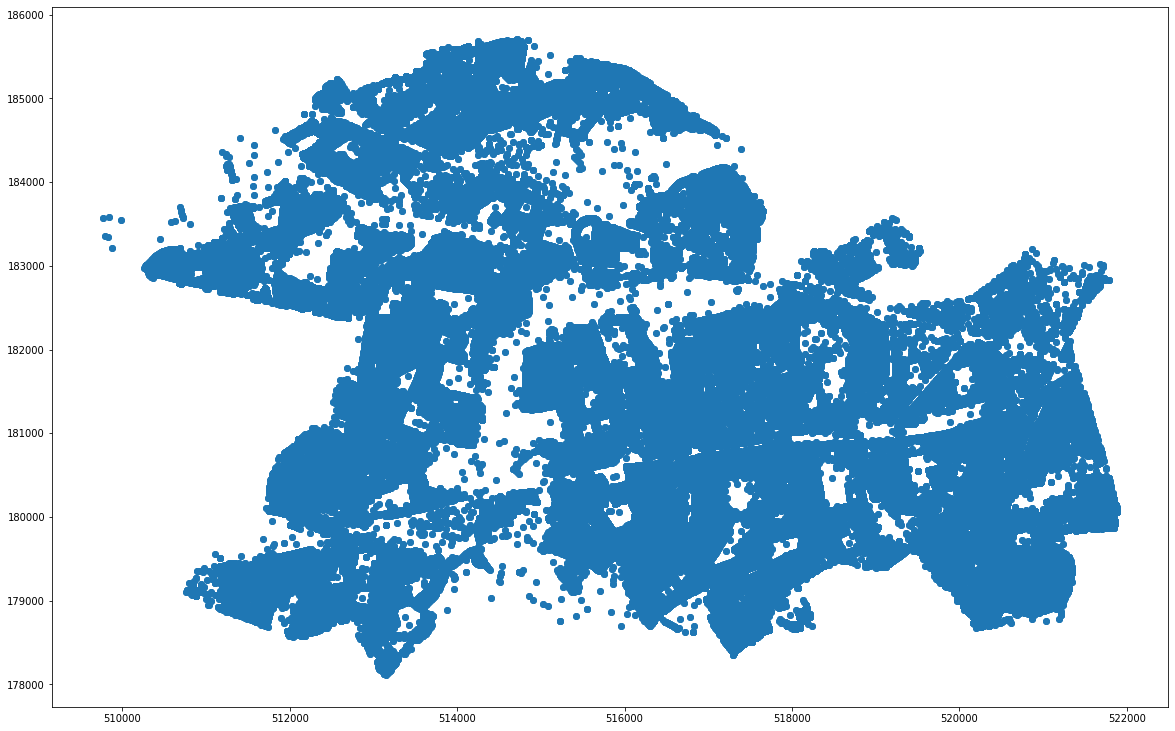

In [66]:
eab.plot(figsize=(20,20))
#think every one of these points is a property

### Ealing topo layer

In [3]:
etl_path = "../data/OSTopographicLayerApril2020_Ealing.gpkg"

In [4]:
for layername in fiona.listlayers(etl_path):
    with fiona.open(etl_path, layer=layername) as src:
        print(layername, len(src))

BoundaryLine 9794
CartographicSymbol 12414
CartographicText 192435
TopographicArea 1457091
TopographicLine 4072454
TopographicPoint 30508


In [5]:
etl = gpd.read_file(etl_path, layer = "TopographicArea")
#really struggled to load "TopograhicArea" never heard the fan so loud... 1.4 million rows...
#and TopographicLine is 3x larger...

(180800, 181000)

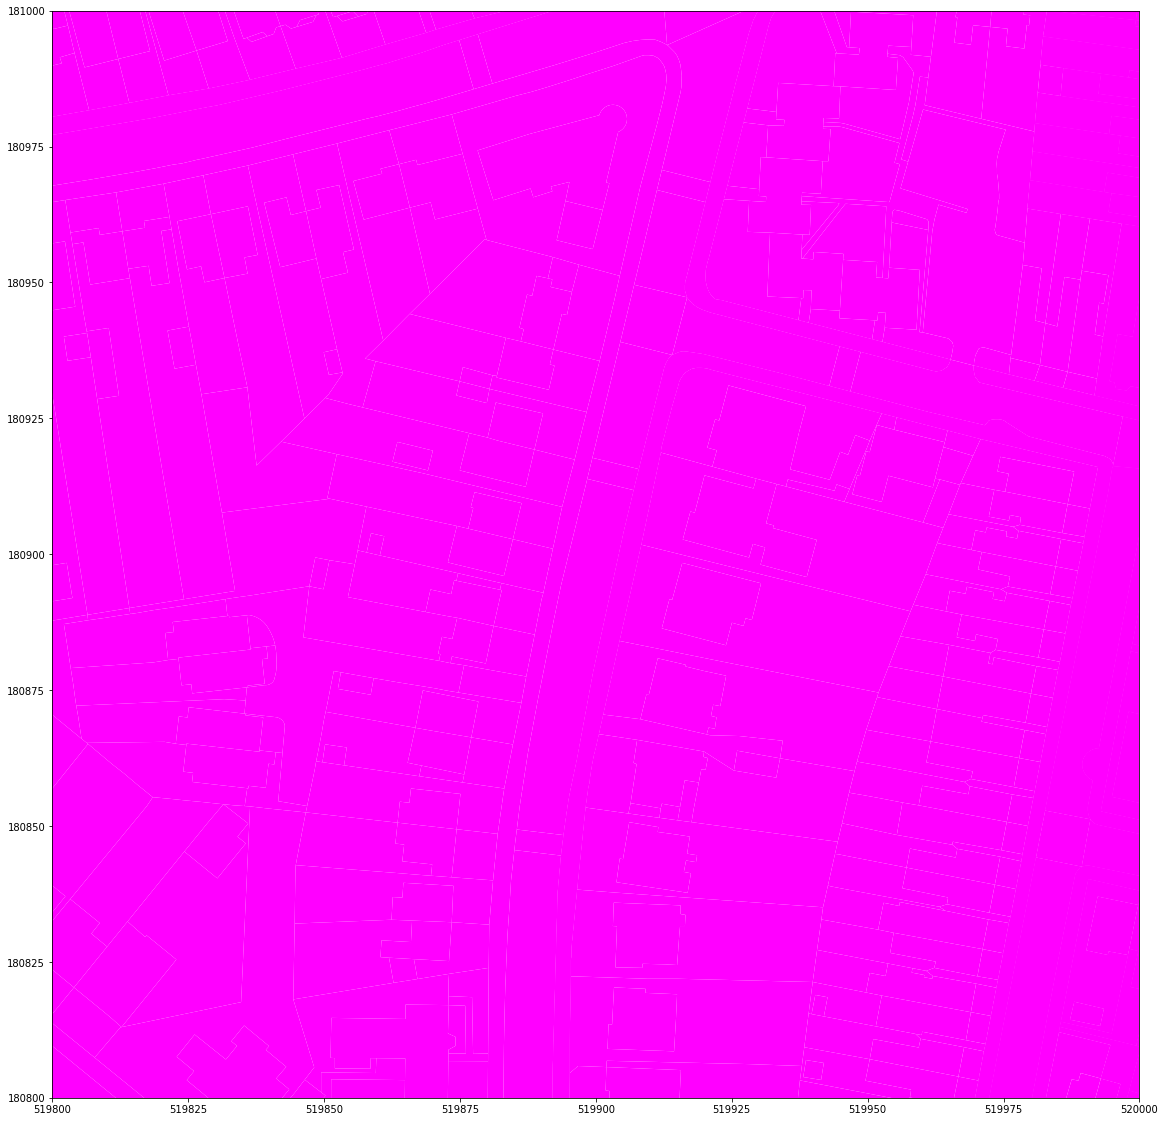

In [98]:
#DO NOT RUN!!!
#base0 = etl.plot(figsize=(20,20), color = "magenta")
#base0.set_xlim(519800, 520000)
#base0.set_ylim(180800,181000)
#this just plots a solid colour because the 2D space is made up of polygons like a jigsaw puzzle
#they all line up to leave no gaps

In [6]:
etl.shape

(1457091, 22)

In [7]:
etl.head()

,OBJECTID,TOID,FeatureCode,Version,VersionDate,Theme,ThemeCount,CalculatedAreaValue,ChangeDate,ReasonForChange,ChangeHistoryCount,DescriptiveGroup,DescriptiveGroupCount,DescriptiveTerm,DescriptiveTermCount,Make,PhysicalLevel,PhysicalPresence,broken,SHAPE_Length,SHAPE_Area,geometry
0,1,5000005224628290,10111,1,2018-03-07T00:00:00,Land,1,3625.081840,2018-03-07T00:00:00,New,1,Natural Environment,1,"Nonconiferous Trees,Scrub",2.0,Natural,50,None,false,506.286233,3625.081840,"POLYGON ((505136.450 182918.050, 505136.900 18..."
1,2,1000001776077422,10089,13,2018-03-08T00:00:00,Water,1,17169.777184,2018-03-07T00:00:00,Reclassified,8,Inland Water,1,Canal,1.0,Natural,50,None,false,1900.773768,17169.779025,"POLYGON ((504982.900 183219.600, 504983.100 18..."
2,3,0001000002260315,10021,5,2018-01-24T00:00:00,Buildings,1,36.733000,2018-01-23T00:00:00,Reclassified,3,Building,1,Electricity Sub Station,1.0,Manmade,50,None,false,24.654611,36.733000,"POLYGON ((505097.750 182627.100, 505096.500 18..."
3,4,1000001776138836,10185,5,2018-01-24T00:00:00,"Roads Tracks And Paths,Structures",2,9.387504,2018-01-23T00:00:00,Reclassified,3,"Path,Structure",2,Footbridge,1.0,Manmade,50,None,false,17.339310,9.387500,"POLYGON ((505056.850 182566.900, 505056.650 18..."
4,5,1000001776138611,10089,5,2018-01-26T00:00:00,"Structures,Water",2,53.868296,2018-01-25T00:00:00,Reclassified,3,"Inland Water,Structure",2,Fountain,1.0,Manmade,50,None,false,48.056323,53.868300,"POLYGON ((505083.440 182851.990, 505085.930 18..."


In [8]:
#count theme types
etl['Theme'].value_counts()

Land                                      716075
Buildings                                 600795
Roads Tracks And Paths                    129112
Rail                                        3533
Roads Tracks And Paths,Structures           2675
Water                                       1498
Structures                                  1298
Land,Rail                                    558
Rail,Structures                              469
Land,Water                                   369
Land,Roads Tracks And Paths                  194
Buildings,Structures                         187
Land,Structures                              160
Structures,Water                              61
Land,Rail,Structures                          52
Land,Roads Tracks And Paths,Structures        29
Rail,Roads Tracks And Paths                   19
Roads Tracks And Paths,Water                   6
Water,Land                                     1
Name: Theme, dtype: int64

In [9]:
etl['DescriptiveGroup'].value_counts()

General Surface                       708395
Building                              600762
Road Or Track                          57069
Roadside                               46577
Path                                   25450
Natural Environment                     4074
Rail                                    3533
Landform                                3113
Inland Water                            1440
Roadside,Structure                      1365
Structure                               1298
Path,Structure                           907
Unclassified                             493
Rail,Structure                           469
Natural Environment,Rail                 422
Road Or Track,Structure                  403
General Surface,Tidal Water              219
Building,Structure                       187
Natural Environment,Roadside             174
General Surface,Structure                159
Landform,Rail                            136
Natural Environment,Tidal Water          130
Inland Wat

In [11]:
dt = etl['DescriptiveTerm'].value_counts().rename_axis("unique_dt").reset_index(name = 'counts')
dt

,unique_dt,counts
0,Multi Surface,603206
1,Traffic Calming,9303
2,Slope,3270
3,Electricity Sub Station,3188
4,Step,2688
...,...,...
89,"Chimney,Pylon",1
90,Coppice Or Osiers,1
91,"Scrub,Nonconiferous Trees (Scattered),Conifero...",1
92,"Bridge,Nonconiferous Trees,Scrub",1


In [13]:
dt[0:40]

,unique_dt,counts
0,Multi Surface,603206
1,Traffic Calming,9303
2,Slope,3270
3,Electricity Sub Station,3188
4,Step,2688
5,"Nonconiferous Trees,Scrub",2110
6,Bridge,1536
7,Nonconiferous Trees,1024
8,Archway,918
9,Tank,860


In [75]:
etl.dtypes

OBJECTID                    int64
TOID                       object
FeatureCode                 int64
Version                     int64
VersionDate                object
Theme                      object
ThemeCount                  int64
CalculatedAreaValue       float64
ChangeDate                 object
ReasonForChange            object
ChangeHistoryCount          int64
DescriptiveGroup           object
DescriptiveGroupCount       int64
DescriptiveTerm            object
DescriptiveTermCount      float64
Make                       object
PhysicalLevel               int64
PhysicalPresence           object
broken                     object
SHAPE_Length              float64
SHAPE_Area                float64
geometry                 geometry
dtype: object

In [20]:
etl_resprop = etl.query("Theme == 'Buildings' & DescriptiveGroup == 'Building'")

In [28]:
etl_resprop_vc = etl_resprop['FeatureCode'].value_counts(dropna=False).rename_axis("unique_value").reset_index(name = 'counts')


In [29]:
etl_resprop_vc

,unique_value,counts
0,10021,600762


In [30]:
etl_resprop['DescriptiveTerm'].value_counts(dropna=False).rename_axis("unique_value").reset_index(name = 'counts')

,unique_value,counts
0,NaN,597607
1,Electricity Sub Station,1701
2,Archway,918
3,Tank,382
4,Public Convenience,136
5,Gas Governor,11
6,Gantry,4
7,Chimney,3


In [65]:
etl_resprop = etl_resprop[etl_resprop["DescriptiveTerm"].isnull()]

In [ ]:
base = etl_resprop.plot(figsize=(20,20))
base.set_xlim(519800, 520000)
base.set_ylim(180800,181000)
#this shows just the buildings, no garden shapes

(180800, 181000)

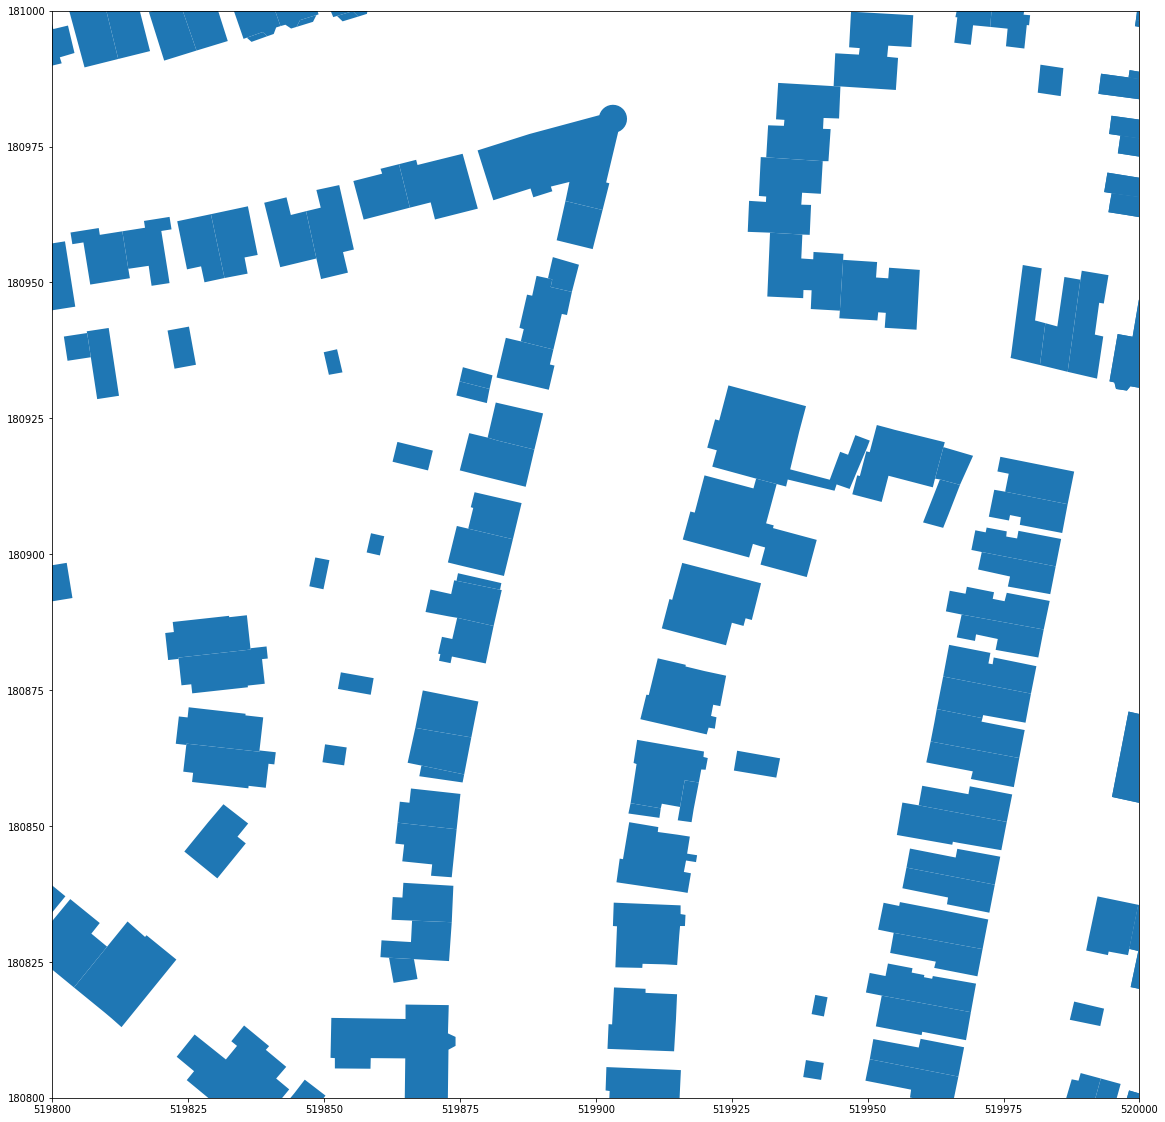

## Look at land theme

In [99]:
etl_land = etl.query("Theme == 'Land'")

AttributeError: 'PatchCollection' object has no property 'colour'

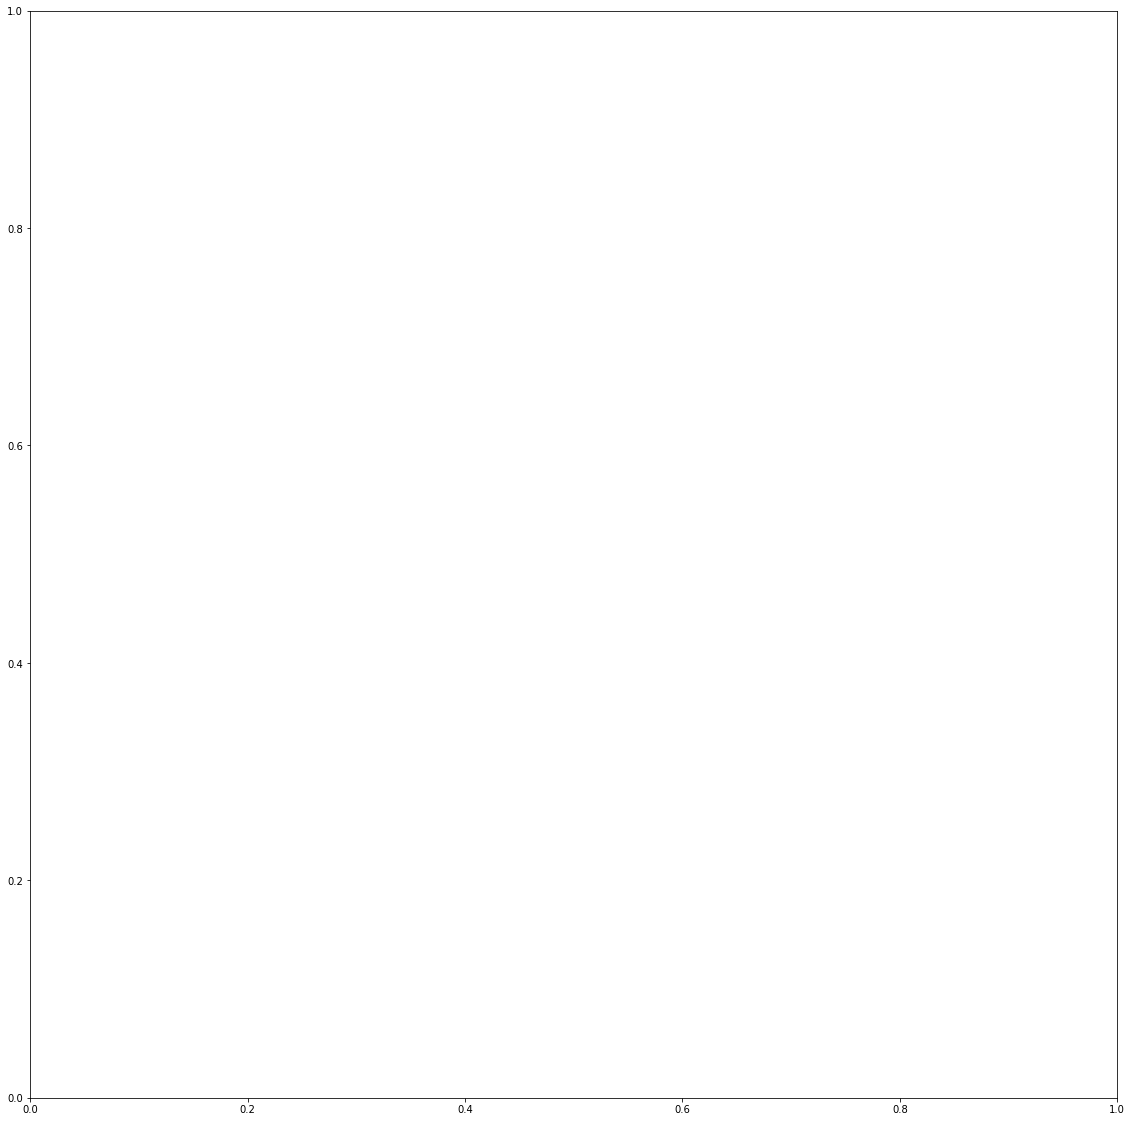

In [100]:
base = etl_land.plot(figsize=(20,20), colour = "green")
base.set_xlim(519800, 520000)
base.set_ylim(180800,181000)

## Look at individual polygons

In [66]:
etl_resprop.head()

,OBJECTID,TOID,FeatureCode,Version,VersionDate,Theme,ThemeCount,CalculatedAreaValue,ChangeDate,ReasonForChange,ChangeHistoryCount,DescriptiveGroup,DescriptiveGroupCount,DescriptiveTerm,DescriptiveTermCount,Make,PhysicalLevel,PhysicalPresence,broken,SHAPE_Length,SHAPE_Area,geometry
6,7,5000005138681088,10021,1,2014-12-18T00:00:00,Buildings,1,296.557078,2014-12-18T00:00:00,New,1,Building,1,None,NaN,Manmade,50,None,false,70.374106,296.557078,"POLYGON ((505112.900 183028.954, 505112.863 18..."
8,9,5000005203199367,10021,1,2017-04-20T00:00:00,Buildings,1,62.476210,2017-04-20T00:00:00,New,1,Building,1,None,NaN,Manmade,50,None,false,32.768893,62.476210,"POLYGON ((505017.801 182692.665, 505018.780 18..."
9,10,5000005203199343,10021,1,2017-04-20T00:00:00,Buildings,1,822.534711,2017-04-20T00:00:00,New,1,Building,1,None,NaN,Manmade,50,None,false,120.961176,822.534711,"POLYGON ((505007.833 182581.190, 505045.666 18..."
10,11,5000005203199342,10021,1,2017-04-20T00:00:00,Buildings,1,327.126476,2017-04-20T00:00:00,New,1,Building,1,None,NaN,Manmade,50,None,false,72.894344,327.126476,"POLYGON ((505011.391 182457.247, 505011.074 18..."
11,12,5000005203199335,10021,1,2017-04-20T00:00:00,Buildings,1,184.820513,2017-04-20T00:00:00,New,1,Building,1,None,NaN,Manmade,50,None,false,54.620278,184.820513,"POLYGON ((505008.525 182516.652, 505020.303 18..."


In [71]:
#create OBJECTID list 
obid_list = [7,9,10]

In [72]:
obid_list

[7, 9, 10]

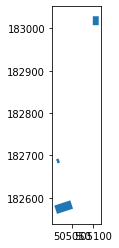

In [73]:
etl_resprop[etl_resprop['OBJECTID'].isin(obid_list)].plot()

In [85]:
bins = []
for i in range(10):
    bins.append(i * 1)
    
bins

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

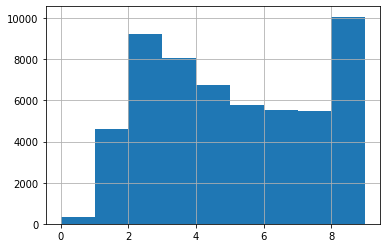

In [86]:

etl_resprop['SHAPE_Area'].hist(bins = bins)

#set geometry
pfv1224 = pfv1224.set_geometry('geom_cen_buff')
print(pfv1224.geometry.name)
#plot
base = pfv1224.plot(alpha = 475, figsize=(10,10), color = 'purple' ) 
base.set_xlim(-11000000, -8500000)
base.set_ylim(-2000000, 2000000)
land.plot(ax = base, color = 'green', alpha = 75)

In [92]:
#create df of those polygons greater than 10 sqm and less than 200 sqm
#2.4 * 4.8 = 11.52 so polygon must be at least bigger than this
etl_sized = etl_resprop.query("SHAPE_Area < 200 & SHAPE_Area > 10" )

(182750, 183000)

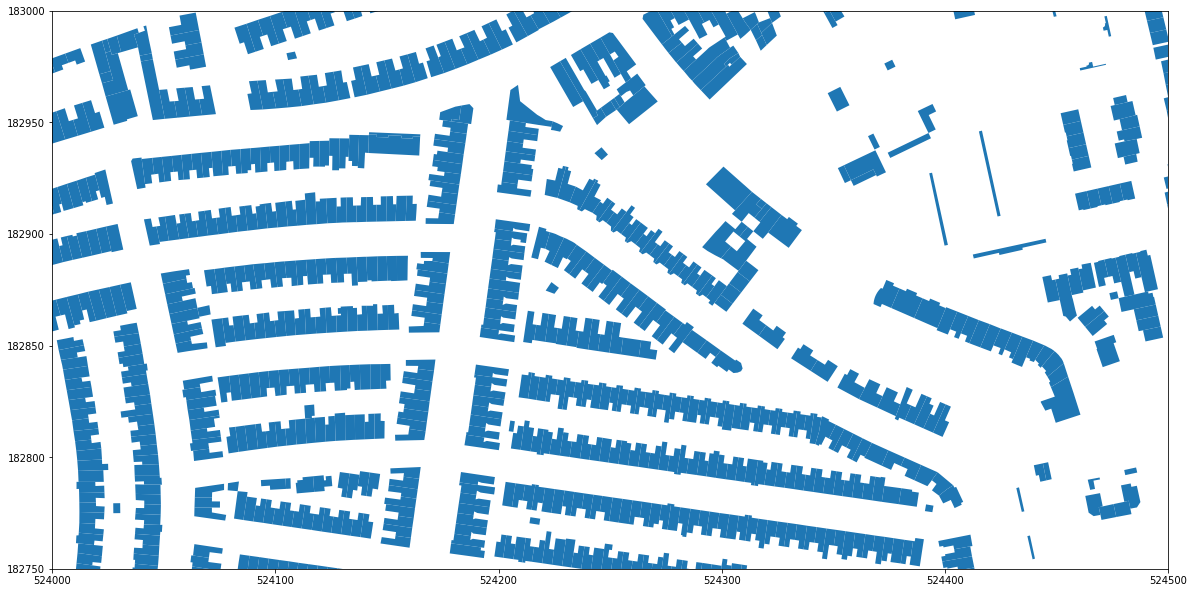

In [93]:
#plot shapes under 200 sqm
base = etl_sized.plot(figsize = (20,20))
base.set_xlim(519800, 520000)
base.set_ylim(180800,181000)


## Ealing topo layers in detail

In [ ]:
etl_path = "../data/OSTopographicLayerApril2020_Ealing.gpkg"

In [ ]:
for layername in fiona.listlayers(etl_path):
    with fiona.open(etl_path, layer=layername) as src:
        print(layername, len(src))

In [ ]:
etl_area = gpd.read_file(etl_path, layer = "TopographicArea")
etl_line = gpd.read_file(etl_path, layer = "TopographicLine")
etl_point = gpd.read_file(etl_path, layer = "TopographicPoint")


## Archive

In [11]:
os.listdir("../data/")

['OSHighwaysNetworkApril2020_Ealing.gpkg',
 'APPenzance_111708_20200602',
 'addressbase-premium-local-custodian-codes',
 'APEaling_111706_20200601',
 '.DS_Store',
 'OSAddressbaseApril2020_Cornwall.gpkg',
 'OSTopographicLayerApril2020_Ealing.gpkg',
 'OSHighwaysNetworkApril2020_Cornwall.gpkg',
 'OS_Open_Zoomstack.gpkg',
 'addressbase-product-classification-scheme',
 'OSAddressbaseApril2020_Ealing.gpkg',
 'opmplc_essh_gb',
 'addressbase-premium-header-files',
 'OSTopographicLayerApril2020_Cornwall.gpkg',
 'bdline_essh_gb']